In [1]:
#필요 라이브러리 임포트
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# interactive graph
import plotly.graph_objects as go
import cufflinks as cf 
import plotly.express as px
cf.go_offline(connected=True)

import seaborn as sns

import platform
path = 'c:/Windows/Fonts/malgun.ttf'
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~~')

In [2]:
titanic_train = pd.read_csv('data/train.csv')
titanic_test = pd.read_csv('data/test.csv')

### 1. 데이터 탐색

In [3]:
print(titanic_train.shape)
titanic_train.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- 12개의 column을 가지고 있고 전체 891개의 데이터

In [5]:
fig = px.bar(titanic_train,title = 'feature 별 null 값 갯수', x=titanic_train.isnull().sum().sort_values(ascending = False).index, y=titanic_train.isnull().sum().sort_values(ascending = False), text = titanic_train.isnull().sum().sort_values(ascending = False),height= 500)
fig.show()

-  **null 값의 개수** : Cabin은 약 700개, Age는 180개의 null값을 가지고 있다.

In [6]:
fig = px.bar(titanic_train,title = '생존자 비율 확인', x=[0,1], y=titanic_train['Survived'].value_counts() / len(titanic_train), text = (titanic_train['Survived'].value_counts() / len(titanic_train)).round(2), color=titanic_train['Survived'].value_counts(),color_continuous_scale=['green','red'],width=600, height= 500)
fig.show()

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

data = titanic_train.groupby(['Sex','Survived'])['Survived'].count()
labels = ["Survived = 0", "Survived = 1"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=[data[2], data[3]], name="male", marker_colors = ["red","green"]),1, 1)
fig.add_trace(go.Pie(labels=labels, values=[data[0], data[1]], name="female"),1, 2)

fig.update_traces(hole=.4)

fig.update_layout(
    title_text="성별에 따른 생존자 비율",
    annotations=[dict(text='Male', x=0.19, y=0.5, font_size=20, showarrow=False),
                 dict(text='Female', x=0.83, y=0.5, font_size=20, showarrow=False)])
fig.show()

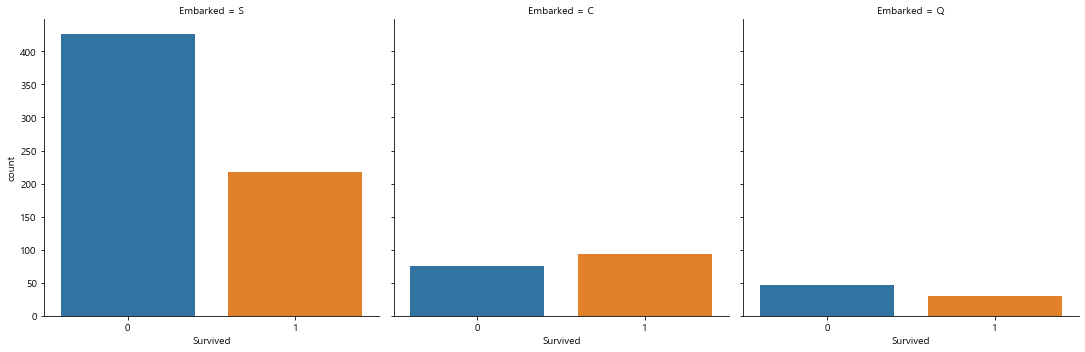

In [8]:
# class 별 생존자 확인
sns.catplot(x='Survived', col='Embarked', kind='count', data=titanic_train)

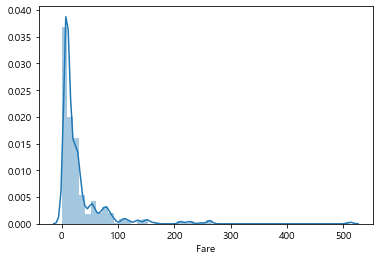

In [9]:
# Fare 분포 확인
sns.distplot(titanic_train['Fare'])

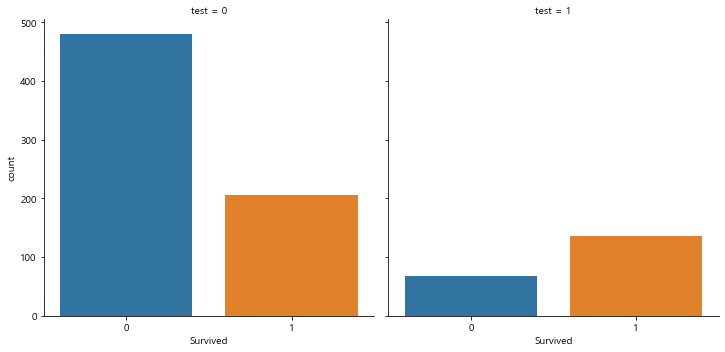

In [10]:
# Cabin 값 유무에 따른 생존자 수 확인
titanic_train['test'] = titanic_train['Cabin'].fillna('N').apply(lambda x : 0 if x[0] == 'N' else 1)

sns.catplot(x='Survived', col='test', kind='count', data=titanic_train)

### 2. 데이터 전처리

In [11]:
def fare(data):
    if data['Age'] == 0:
        if data.Embarked == 'C':
            if data.Pclass == 1:
                return 36.5
            elif data.Pclass == 2:
                return 25
            else:
                return 20
        elif data.Embarked == 'S':
            if data.Pclass == 1:
                return 37
            elif data.Pclass == 2:
                return 30
            else:
                return 25
        else:
            # Q에 대한 인원이 많지 않아 하나로 통합
            return 27
    else:
        return data['Age']

# 0.9563
def data_processing(df):
    # Age null 값 채우기 / Embarked & Pclass 별 Age 중앙값
    df['Age'].fillna(0, inplace=True)
    df['new_Age'] = df[['Embarked', 'Pclass', 'Age']].apply(fare, axis = 1)
    df.drop(['new_Age'], axis = 1, inplace = True)
    
    # Cabin 값이 있는 경우 / 없는 경우
    df['Cabin'].fillna('N',inplace=True)
    df['Cabin'] =  df['Cabin'].apply(lambda x : 0 if x[0] == 'N' else 1)
    
    
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(df['Fare'].median(),inplace=True)
    
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
        
    # df['Cabin'] = df['Cabin'].str[:1]
    features = ['Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    
    return df

In [12]:
titanic_df = pd.read_csv('data/train.csv')
titanic_test = pd.read_csv('data/test.csv')

In [13]:
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived',axis=1)

X_titanic_df = data_processing(X_titanic_df)

X_titanic_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,0,3
1,1,0,38.0,1,0,71.2833,1,0
2,3,0,26.0,0,0,7.9250,0,3
3,1,0,35.0,1,0,53.1000,1,3
4,3,1,35.0,0,0,8.0500,0,3


### 3. 데이터 분석

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss',
           'early_stoppings':100
        }
num_rounds = 400


# 0.8328
def data_analysis(data):
    X_train, X_test, y_train, y_test=train_test_split(data.iloc[:,1:], data.iloc[:,0],random_state=10)
    evals = [(X_test, y_test)]
 
    dt_clf = DecisionTreeClassifier(random_state=0)
    rf_clf = RandomForestClassifier(random_state=0)
    lr_clf = LogisticRegression()
    knn_clf = KNeighborsClassifier(n_neighbors=10)
    gb_clf = GradientBoostingClassifier(random_state=0)
    
    xgb_clf = XGBClassifier(n_estimators=300, learning_rate=0.01, max_depth=5)
    
    xgb_clf.fit(X_train , y_train, eval_metric="logloss",  verbose=True)
    pred = xgb_clf.predict(X_test)
    print('{0} 정확도: {1:.4f}'.format(xgb_clf.__class__.__name__, accuracy_score(y_test , pred)))
    
    # voting : 0.87 / rf, xgb
    vo_clf = VotingClassifier( estimators=[# ('dt',dt_clf),
                                           # ('rf',rf_clf),
                                           # ('lr',lr_clf),
                                           # ('knn',knn_clf),
                                           ('gb',gb_clf),
                                           ('xgb',xgb_clf)]
                              ,voting='soft'
                             ,weights=[2,1])
    vo_clf.fit(X_train , y_train)
    pred = vo_clf.predict(X_test)
    print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

    # 개별 모델의 학습/예측/평가.
    classifiers = [dt_clf, rf_clf, lr_clf, knn_clf, gb_clf]
    for classifier in classifiers:
        classifier.fit(X_train , y_train)
        pred = classifier.predict(X_test)
        class_name= classifier.__class__.__name__
        print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))
    
    # result = rf_pred
    print()
    print()
    # exec_kfold 호출
    classifiers = [gb_clf, rf_clf, xgb_clf, vo_clf]
    for classifier in classifiers:
        print(classifier.__class__.__name__)
        exec_kfold(data, classifier)
        print()
        print()

In [15]:
def exec_kfold(data, clf, folds=7):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    kfold = KFold(n_splits=folds, shuffle=True,random_state=2)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count , (train_index, test_index) in enumerate(kfold.split(data.iloc[:,1:])):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = data.iloc[:,1:].values[train_index], data.iloc[:,1:].values[test_index]
        y_train, y_test = data.iloc[:,0].values[train_index], data.iloc[:,0].values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train) 
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score)) 

In [16]:
data_analysis(X_titanic_df)

XGBClassifier 정확도: 0.9596
Voting 분류기 정확도: 0.9462
DecisionTreeClassifier 정확도: 0.9327
RandomForestClassifier 정확도: 0.9238
LogisticRegression 정확도: 0.8027
KNeighborsClassifier 정확도: 0.8161
GradientBoostingClassifier 정확도: 0.9462


GradientBoostingClassifier
교차 검증 0 정확도: 0.9219
교차 검증 1 정확도: 0.9922
교차 검증 2 정확도: 0.9528
교차 검증 3 정확도: 0.9843
교차 검증 4 정확도: 0.9606
교차 검증 5 정확도: 0.9055
교차 검증 6 정확도: 0.9370
평균 정확도: 0.9506


RandomForestClassifier
교차 검증 0 정확도: 0.9219
교차 검증 1 정확도: 0.9531
교차 검증 2 정확도: 0.9291
교차 검증 3 정확도: 0.9370
교차 검증 4 정확도: 0.9213
교차 검증 5 정확도: 0.9370
교차 검증 6 정확도: 0.9213
평균 정확도: 0.9315


XGBClassifier
교차 검증 0 정확도: 0.8672
교차 검증 1 정확도: 0.9766
교차 검증 2 정확도: 0.9291
교차 검증 3 정확도: 0.9685
교차 검증 4 정확도: 0.9449
교차 검증 5 정확도: 0.9055
교차 검증 6 정확도: 0.9291
평균 정확도: 0.9316


VotingClassifier
교차 검증 0 정확도: 0.9141
교차 검증 1 정확도: 0.9844
교차 검증 2 정확도: 0.9528
교차 검증 3 정확도: 0.9843
교차 검증 4 정확도: 0.9606
교차 검증 5 정확도: 0.9055
교차 검증 6 정확도: 0.9291
평균 정확도: 0.9472


